# 프로젝트 : 고양이 수염 스티커 만들기(feat. 국민MC)

# 1. 기본 이미지 적용하기

## 사진 준비하기

### 이미지 불러오기

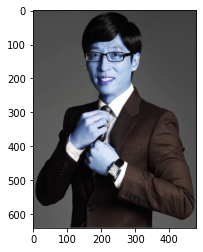

In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import os

image_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/mcyoo.png'
img_bgr = cv2.imread(image_path)  # OpenCV로 이미지 읽기
img_bgr = cv2.resize(img_bgr, (480, 640))  # 이미지 resize(두번째 파라미터에 사이즈를 입력해준다.)
img_show = img_bgr.copy()  # 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

### 이미지 색상 보정

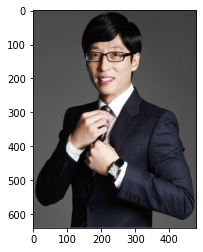

In [28]:
# RGB로 출력
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # plt.imshow 이전에 RGB 이미지로 변경!
plt.imshow(img_rgb)
plt.show()

## 얼굴 검출 및 랜드마크 검출하기

### 얼굴 검출(Face detection)

In [29]:
# dlib를 활용해 hog detector 선언하기
import dlib
detector_hog = dlib.get_frontal_face_detector()

# detector를 이용해 얼굴의 bounding box 추출하기
# cvtColor()
# dlib는 rgb로 이미지를 입벽받기 때문에 bgr 2 rgb 필요
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 두번째 파라미터는 이미지 피라미드 수
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)

__이미지 피라미드__
- 두번째 파라미터는 이미지 피라미드 수
- 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다.
- 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능

### 검출한 얼굴 출력

rectangles[[(132, 81) (287, 236)]]


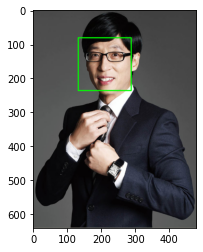

In [30]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 얼굴 랜드마크(Face lnadmark)

### dlib landmark localization

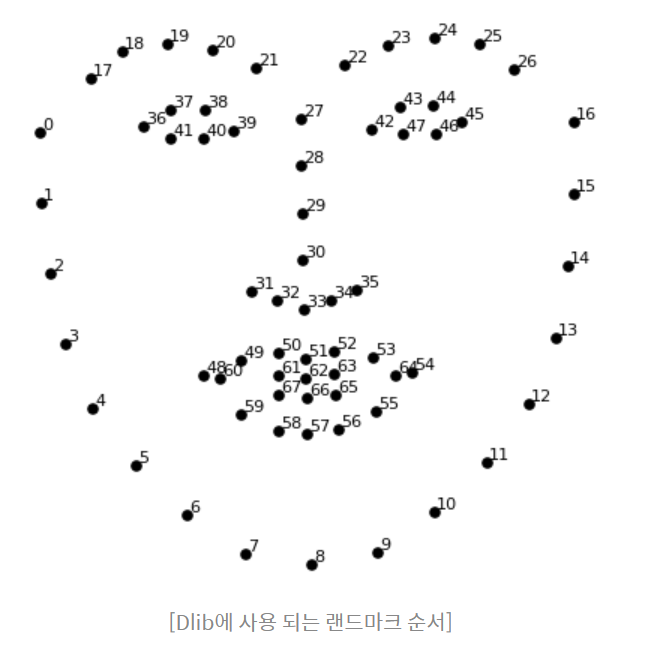

In [31]:
# landmark 모델 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


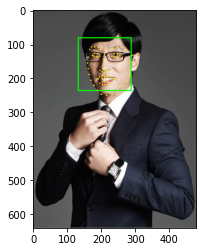

In [32]:
# 이미지에 landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 스티커 적용하기

### 스티커 위치 및 크기 계산

In [33]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print("고양이 스티커 기준점이 되는 좌표는 :", landmark[30])
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x,y) : (%d, %d)'%(x,y))  # 스티커의 위치 (x,y)
    print('(w,h) : (%d, %d)'%(w,h))  # 스티커의 크기 (w,h)

고양이 스티커 기준점이 되는 좌표는 : (206, 171)
(x,y) : (206, 171)
(w,h) : (156, 156)


### 스티커 resize & 좌표 조정

(156, 156, 3)


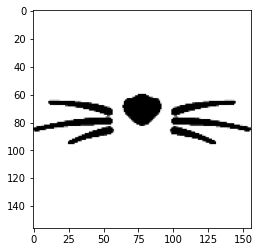

In [34]:
# 스티커 이미지를 읽어와 윗 단계에서 계산한 크기로 resize
import os
sticker_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

In [35]:
# 이미지의 시작점(top-left) x, y 좌표 조정
refined_x = x - w // 2 #left
refined_y = y - h // 2 # top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (128,93)


### 결과 이미지 출력

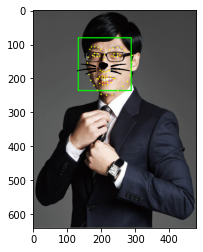

In [36]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### bounding box, landmark 제거 후 최종 이미지 출력

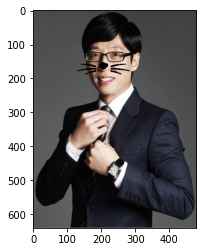

In [37]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 2. 다른 이미지에도 적용해보기
- 다른 각도, 어두운 사진, 마스크 쓴 사진 등

## 2-1. 45도 사진

### 이미지 불러오기

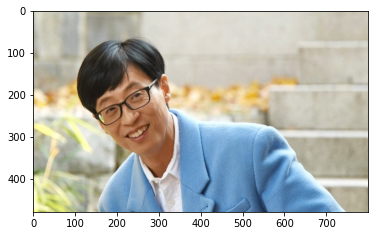

In [38]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
image_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/mcyoo_45.png'
img_bgr = cv2.imread(image_path)  # OpenCV로 이미지 읽기
img_bgr = cv2.resize(img_bgr, (800, 480))  # 660 X 371 사이즈로 resize 
img_show = img_bgr.copy()  # 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 얼굴 검출(Face detection)

rectangles[[(139, 160) (324, 345)]]


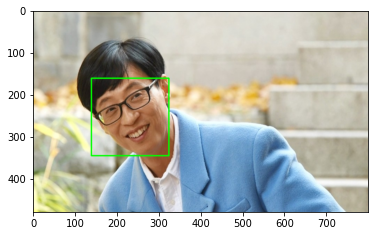

In [39]:
# dlib를 활용해 hog detector 선언하기
import dlib
detector_hog = dlib.get_frontal_face_detector()  # detector 선언

# detector를 이용해 얼굴의 bounding box 추출하기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # (image, num of img pyramid)
dlib_rects = detector_hog(img_rgb, 1) # dlib는 rgb로 이미지를 입력 받음, cvtColor 이용 opencv bgr 이미지를 rgb로 전환

# 찾은 얼굴을 화면에 출력하기

print(dlib_rects) # 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 얼굴 랜드마크(Face landmark)

68


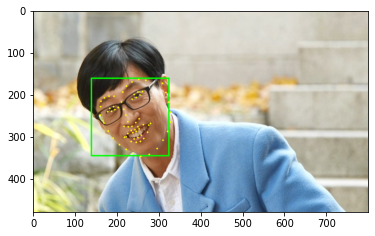

In [40]:
import os
model_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 스티커 적용하기

고양이 스티커 기준점이 되는 좌표는 : (226, 264)
(x,y) : (226, 264)
(w,h) : (186, 186)
고양이 스티커 shape : (186, 186, 3)


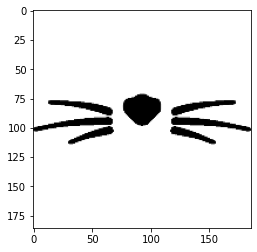

(x,y) : (133,171)


In [41]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print("고양이 스티커 기준점이 되는 좌표는 :", landmark[30])
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x,y) : (%d, %d)'%(x,y))
    print('(w,h) : (%d, %d)'%(w,h))

print('==========================================================')

# 스티커 이미지를 읽어와 윗 단계에서 계산한 크기로 resize
import os
sticker_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print("고양이 스티커 shape :", img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

print('==========================================================')

# 이미지의 시작점(top-left) x, y 좌표 조정
refined_x = x - w // 2 #left
refined_y = y - h // 2 # top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

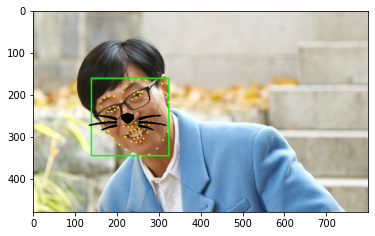

In [42]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 최종 이미지 출력

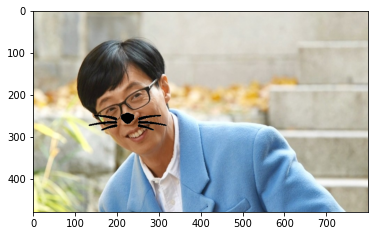

In [43]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

얼굴 검출과 랜드마크는 잘 되었으나 얼굴 각도에 따른 스티커 각도가 맞지 않았다. 아마도 스티커를 회전 시켜서 맞춰주는 방법이 있을 듯하다.

### 2-2. 어두운 사진

### 이미지 불러오기

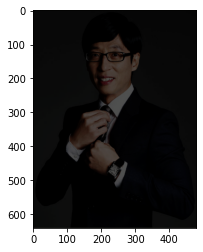

In [44]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
image_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/mcyoo_dark.png'
img_bgr = cv2.imread(image_path)  # OpenCV로 이미지 읽기
img_bgr = cv2.resize(img_bgr, (480, 640)) 
img_show = img_bgr.copy()  # 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 얼굴 검출(Face detection)

rectangles[[(132, 81) (287, 236)]]


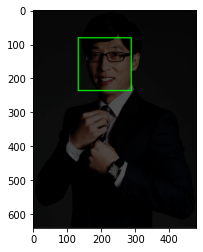

In [45]:
# dlib를 활용해 hog detector 선언하기
import dlib
detector_hog = dlib.get_frontal_face_detector()  # detector 선언

# detector를 이용해 얼굴의 bounding box 추출하기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # (image, num of img pyramid)
dlib_rects = detector_hog(img_rgb, 1) # dlib는 rgb로 이미지를 입력 받음, cvtColor 이용 opencv bgr 이미지를 rgb로 전환

# 찾은 얼굴을 화면에 출력하기

print(dlib_rects) # 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 얼굴 랜드마크(Face landmark)

68


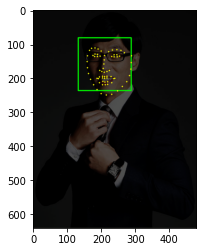

In [46]:
import os
model_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

# 
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 스티커 적용하기

(208, 182)
(x,y) : (208, 182)
(w,h) : (156, 156)
(156, 156, 3)


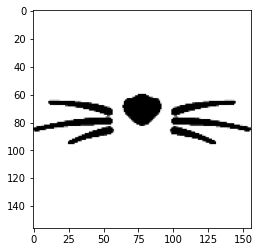

(x,y) : (130,104)


In [47]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33]) 
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x,y) : (%d, %d)'%(x,y))
    print('(w,h) : (%d, %d)'%(w,h))

print('==========================================================')

# 스티커 이미지를 읽어와 윗 단계에서 계산한 크기로 resize
import os
sticker_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

print('==========================================================')

# 이미지의 시작점(top-left) x, y 좌표 조정
refined_x = x - w // 2 #left
refined_y = y - h // 2 # top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

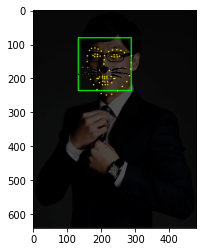

In [48]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 최종 이미지 출력

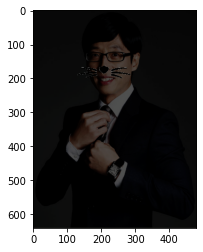

In [49]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

정면 이미지의 밝기를 조절하여 사용했으나, 이미지의 각도 변화나 밝기가 더 어두울 경우 인식이 안되는 경우도 있을 것으로 예상된다.

## 2-3. 마스크 쓴 사진

### 이미지 불러오기

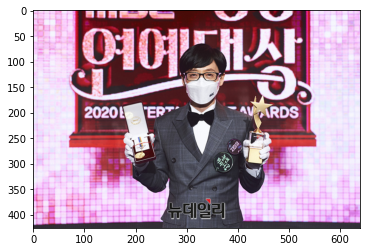

In [50]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
image_path = os.getenv('HOME')+'/aiffel/exploration/E03/camera_sticker/images/mcyoo_mask.png'
img_bgr = cv2.imread(image_path)  # OpenCV로 이미지 읽기
img_show = img_bgr.copy()  # 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 얼굴 검출(Face detection)

rectangles[]


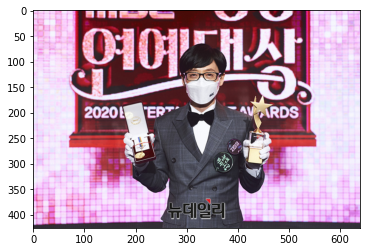

In [51]:
# dlib를 활용해 hog detector 선언하기
import dlib
detector_hog = dlib.get_frontal_face_detector()  # detector 선언

# detector를 이용해 얼굴의 bounding box 추출하기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # (image, num of img pyramid)
dlib_rects = detector_hog(img_rgb, 1) # dlib는 rgb로 이미지를 입력 받음, cvtColor 이용 opencv bgr 이미지를 rgb로 전환

# 찾은 얼굴을 화면에 출력하기

print(dlib_rects) # 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 마스크를 써서 인지 얼굴 검출이 안되었다.
구글링을 해보니 추후에 다음과 같은 내용을 참고하면 마스크를 인식하게 해서 Face detction이 가능할 것 같다.  
- [실제적 영상처리 프로젝트 - 마스크 착용 인식](http://ailab.silla.ac.kr/lec/ip/Chap.%2010%20%EC%8B%A4%EC%A0%9C%EC%A0%81%20%EC%98%81%EC%83%81%EC%B2%98%EB%A6%AC%20%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8%20-%20%EB%A7%88%EC%8A%A4%ED%81%AC%20%EC%B0%A9%EC%9A%A9%20%EC%9D%B8%EC%8B%9D.pdf)

# 3. 회고

### 다양한 이미지 유형에 스티커 적용
- __정면 사진__ : 큰 문제 없이 결과가 아주 잘 나왔다. 다만, 주변 사람들의 얘기를 들어보니 이미지 픽셀 사이즈에 따라서 Face detection이 안되는 경우도 있다고 하는데 이미지 해상도가 낮을 경우 굳이 리사이즈를 하지 않고 원본을 사용해도 무방할 것 같다.  
- __다른 각도__ : 스티커 적용까지는 성공하였으나 얼굴 각도에 맞게 스터커 회전시키는 방법을 모르는 상태에서 시간이 부족해 해결하지 못하였다.
- __어두운 사진__ : 우선 내가 적용한 사진은 결과가 잘 나왔다. 하지만 이것도 이미지의 각도나 밝기의 정도에 따라 인식이 잘 안되는 경우가 있을 것이라 예상 해본다.
- __마스크를 쓴 경우__ : 시국이 시국이다 보니 과연 적용이 가능할지 매우 궁금했다. 하지만 Face detection부터 실패했다. 구글링을 해보니 프로젝트로 마스크를 쓴 이미지를 인식하는 프로젝트가 몇개 보이는 것으로 보아 실력이 된다면 구현은 가능한 것 같다.

### 새롭게 알게 된 사실

- __계산, 또 계산__ : 아이펠 공부를 하기 전까지 카메라 어플에 나와있는 이러한 스티커를 관심있게 보지 않았는데 직접 만들어보니 정말 계산이 많이 필요하고 구현하기 쉽지 않다는 걸 느꼈다.
- __스티커 배경 문제__ : 처음에 고양이 수염 이미지를 불러온 뒤 파일의 뒷 배경이 투명이 아닌 흰색이여서 이걸 날려주는 작업을 해야 할 것 같아 여러번 시도 해봤는데 잘 안되었다. 계속 png 파일이 채널 값을 하나 더 갖기 때문에 그렇다고 생각했는데 그게 아니라 np.where()의 조건을 바꿔주면서 해결할 수 있었다. np.where(조건,x,y) 형태로 사용되기 때문에 조건을 image_sticker==0이 아닌 image_sticke==255로 수정해주니 정상적으로 이미지가 출력되었다.혹은 x,y의 위치를 바꿔주면 image_sticker==0을 적용해도 정상적으로 이미지가 투명하게 출력 되는 것을 확인할 수 있었다.

### 더 고민해볼 수 있는 것들
- 이미지 자체를 45도, 90도, 180도 등으로 회전시킨 뒤 스티커 적용이 가능한지?
- 이미지 안에 사람이 2인 이상이어도 모두 인식할 수 있는지?
- 멀리 있는 원거리 이미지도 잘 인식할 수 있는지?
- 스티커를 얼굴 각도에 맞춰 회전 시켜 적용하는 것